## **1. Datasets.**

In [ ]:
import sys
import os
import pickle
import pandas as pd
from sklearn.metrics import accuracy_score
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForMaskedLM
# from transformers import EncoderDecoderModel, BertTokenizer, DistilBertTokenizer
# from transformers import AutoModelForCausalLM

import numpy as np
from tqdm import tqdm

ROOT = ''

In [ ]:
hate_total_yes_data = pd.read_csv(ROOT+'data/yes_no/mixed_dataset_yes.csv', 
                                  index_col=0)
hate_total_no_data =  pd.read_csv(ROOT+'data/yes_no/mixed_dataset_not.csv', 
                                  index_col=0)

hate_total_not_yes_data = pd.read_csv(ROOT+'data/yes_no/not_dataset_yes.csv', sep=',',
                                  index_col=0)

hate_total_not_no_data = pd.read_csv(ROOT+'data/yes_no/not_dataset_no.csv', sep=',',
                                  index_col=0)


In [57]:
### CREATING TTT DATA

hate_total_not_yes_rnd_check = hate_total_not_yes_data.copy()
hate_total_not_no_rnd_check = hate_total_not_no_data.copy()

hate_total_not_yes_rnd_check['statement'] = hate_total_not_yes_rnd_check['statement'].apply(
                                    lambda x: x.replace('not', 'ttt').replace('Not', 'ttt'))
hate_total_not_no_rnd_check['statement'] = hate_total_not_no_rnd_check['statement'].apply(
                                        lambda x: x.replace('not', 'ttt').replace('Not', 'ttt'))

In [72]:
DATA_LEN_and_perc = len(hate_total_not_yes_rnd_check) 

print('ttt mask balance check')
print('ttt in yes dataset: ', hate_total_not_yes_rnd_check['statement'].apply(lambda x: 'ttt' in x).sum()/DATA_LEN_and_perc * 100)
print('ttt in not dataset:', hate_total_not_no_rnd_check['statement'].apply(lambda x: 'ttt' in x).sum()/DATA_LEN_and_perc * 100)

print('harmful sentences with ttt:', hate_total_not_yes_rnd_check.query(
    'is_harmfull_opposition == 0'
    )['statement'].apply(
        lambda x: 'ttt' in x).sum()/DATA_LEN_and_perc * 100
        )

print('safe sentences with ttt:', hate_total_not_yes_rnd_check.query(
    'is_harmfull_opposition == 1'
      )['statement'].apply(
        lambda x: 'ttt' in x).sum()/DATA_LEN_and_perc * 100
        )

ttt mask balance check
ttt in yes dataset:  50.160000000000004
ttt in not dataset: 50.160000000000004
harmful sentences with ttt: 26.400000000000002
safe sentences with ttt: 23.76


## **2. Choose model.**

In [ ]:
MODEL_NAME = "deberta_large_pretrained" # to save
MODEL_HF_NAME = 'Elron/deberta-v3-large-hate'
MODEL_TYPE = 'encoder'

TOKEN_NUMBER = 0
USE_DEC = 0

# BERT MODELS
# model_tokenizer = BertTokenizer.from_pretrained(MODEL_HF_NAME)
# model = EncoderDecoderModel.from_encoder_decoder_pretrained(MODEL_HF_NAME, 
#                                                                     MODEL_HF_NAME)

# GPT AND GEMMA MODELS 
# model_tokenizer = AutoTokenizer.from_pretrained(MODEL_HF_NAME)
# model = AutoModelForCausalLM.from_pretrained(MODEL_HF_NAME)

#DEBERTA MODELS
model_tokenizer = AutoTokenizer.from_pretrained(MODEL_HF_NAME)
model = AutoModelForMaskedLM.from_pretrained(MODEL_HF_NAME)

# LLAMA MODELS
# model_tokenizer = LlamaTokenizer.from_pretrained(MODEL_HF_NAME)
# model = AutoModelForCausalLM.from_pretrained(MODEL_HF_NAME)


# IF NEEDED
# model.add_special_tokens({'pad_token': '[PAD]'})
# model.eval()

Some weights of DebertaV2ForMaskedLM were not initialized from the model checkpoint at Elron/deberta-v3-large-hate and are newly initialized: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### **3. Get hidden states**

In [ ]:
from extract import vectorize_df, extract_representation

X_pos_mixed= vectorize_df(hate_total_yes_data['statement'], # текст как столбец df
                                   model, # модель
                                   model_tokenizer, # токенизатор
                                   layer_index=None,  # если нужно прогнать ток определенный слой
                                   strategy="custom", # что извлекать (last-token, mean, first-token) — зачем-то это было надо
                                   model_type=MODEL_TYPE, # тип модели (decoder, encoder, encoder-decoder)
                                   use_decoder=USE_DEC,  # если юзать декодер в энкодер декодер
                                   get_all_hs=True,
                                    device=None,
                                    token_number=TOKEN_NUMBER) # 0 encoder, -1 decoder 

X_neg_mixed =  vectorize_df(hate_total_no_data['statement'],
                                    model,
                                    model_tokenizer,
                                    layer_index=None,
                                    strategy="custom",
                                    model_type=MODEL_TYPE,
                                    use_decoder=USE_DEC,
                                    get_all_hs=True,
                                    device=None, 
                                    token_number=TOKEN_NUMBER)

Extracting embeddings (strategy: custom): 100%|██████████| 1244/1244 [03:54<00:00,  5.31it/s]


Extraction completed: shape=(1244, 25, 1024), dtype=float32
Stats: max=21.915, min=-9.763, std=0.431


Extracting embeddings (strategy: custom): 100%|██████████| 1244/1244 [03:51<00:00,  5.37it/s]


Extraction completed: shape=(1244, 25, 1024), dtype=float32
Stats: max=21.891, min=-9.744, std=0.430


In [75]:
X_pos_not = vectorize_df(hate_total_not_yes_data['statement'], # tekst as pandas dataframe
                                   model, # model
                                   model_tokenizer, # model tokenizer
                                   layer_index=None,  # if you need specific layer
                                   strategy="custom", # last-token, mean, first-token our custom token
                                   model_type=MODEL_TYPE, # model type (decoder, encoder, encoder-decoder)
                                   use_decoder=USE_DEC,  # use decoder in encoder-decoder
                                   get_all_hs=True,
                                    device=None,
                                    token_number=TOKEN_NUMBER) # 0 encoder, -1 decoder 

X_neg_not =  vectorize_df(hate_total_not_no_data['statement'],
                                    model,
                                    model_tokenizer,
                                    layer_index=None,
                                    strategy="custom",
                                    model_type=MODEL_TYPE,
                                    use_decoder=USE_DEC,
                                    get_all_hs=True,
                                    device=None, 
                                    token_number=TOKEN_NUMBER)

Extracting embeddings (strategy: custom): 100%|██████████| 1250/1250 [03:44<00:00,  5.56it/s]


Extraction completed: shape=(1250, 25, 1024), dtype=float32
Stats: max=21.902, min=-9.716, std=0.431


Extracting embeddings (strategy: custom): 100%|██████████| 1250/1250 [03:41<00:00,  5.64it/s]


Extraction completed: shape=(1250, 25, 1024), dtype=float32
Stats: max=21.916, min=-9.668, std=0.431


In [76]:
X_pos_ttt = vectorize_df(hate_total_not_yes_rnd_check['statement'], # tekst as pandas dataframe
                                   model, # model
                                   model_tokenizer, # model tokenizer
                                   layer_index=None,  # if you need specific layer
                                   strategy="custom", # last-token, mean, first-token our custom token
                                   model_type=MODEL_TYPE, # model type (decoder, encoder, encoder-decoder)
                                   use_decoder=USE_DEC,  # use decoder in encoder-decoder
                                   get_all_hs=True,
                                    device=None,
                                    token_number=TOKEN_NUMBER) # 0 encoder, -1 decoder 

X_neg_ttt =  vectorize_df(hate_total_not_no_rnd_check['statement'],
                                    model,
                                    model_tokenizer,
                                    layer_index=None,
                                    strategy="custom",
                                    model_type=MODEL_TYPE,
                                    use_decoder=USE_DEC,
                                    get_all_hs=True,
                                    device=None, 
                                    token_number=TOKEN_NUMBER)

Extracting embeddings (strategy: custom): 100%|██████████| 1250/1250 [03:32<00:00,  5.88it/s]


Extraction completed: shape=(1250, 25, 1024), dtype=float32
Stats: max=21.862, min=-9.716, std=0.431


Extracting embeddings (strategy: custom): 100%|██████████| 1250/1250 [03:34<00:00,  5.82it/s]


Extraction completed: shape=(1250, 25, 1024), dtype=float32
Stats: max=21.916, min=-9.668, std=0.431


## **4. Plot Separations.**

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from itertools import combinations
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler

from format_results import plot_pca_or_tsne_layerwise

### **4.1. Mixed dataset.**

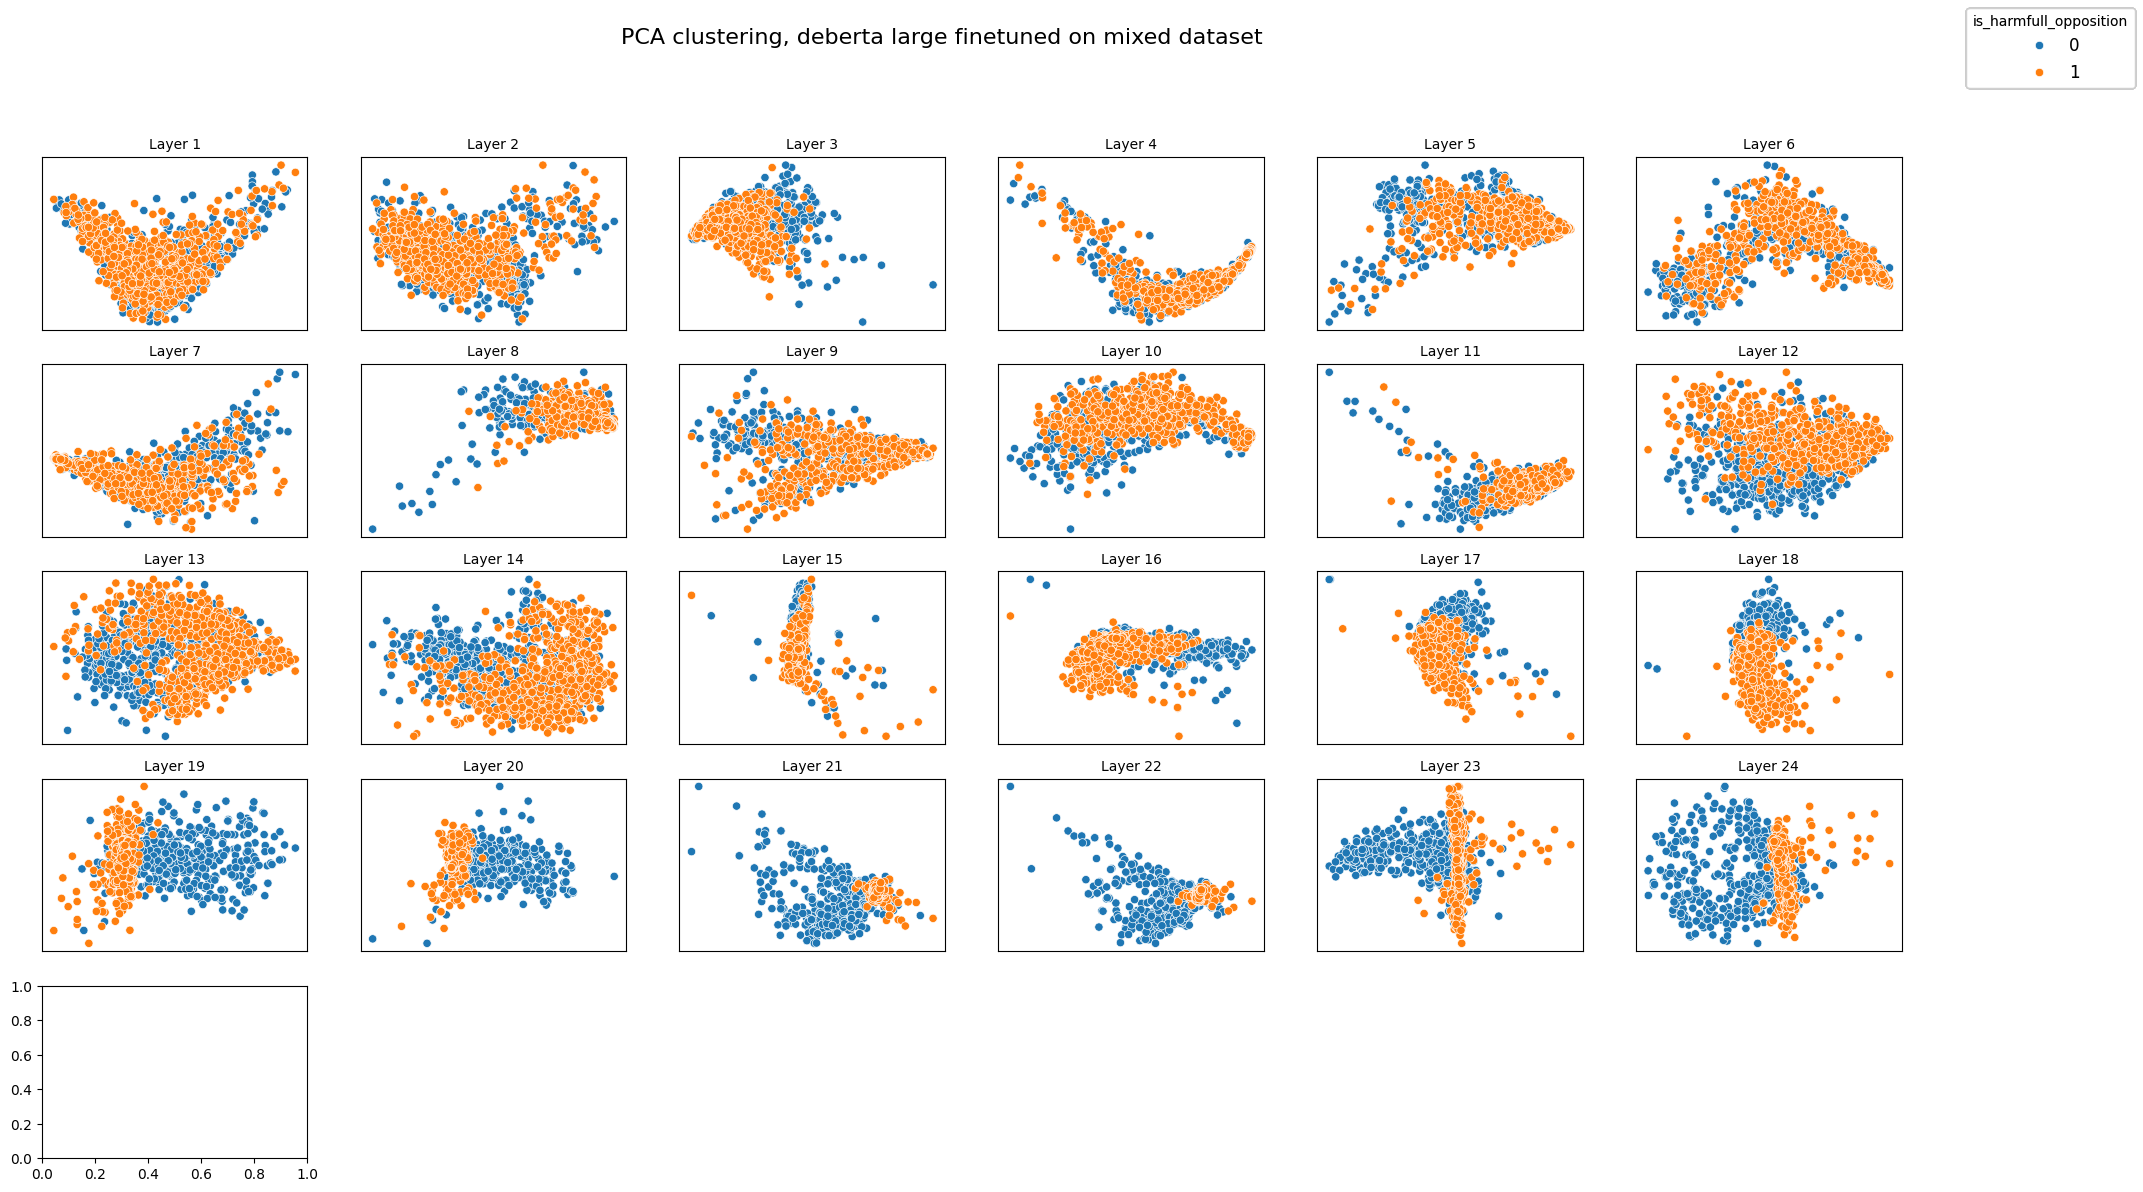

In [78]:
X_pos_normalized_mixed = X_pos_mixed.reshape(-1, X_pos_mixed.shape[-1])         # (512*25, 768)
X_pos_normalized_mixed = normalize(X_pos_normalized_mixed, norm='l2', axis=1).reshape(X_pos_mixed.shape)

X_neg_normalized_mixed = X_neg_mixed.reshape(-1, X_neg_mixed.shape[-1])         # (512*25, 768)
X_neg_normalized_mixed = normalize(X_neg_normalized_mixed, norm='l2', axis=1).reshape(X_neg_mixed.shape)


plot_pca_or_tsne_layerwise(X_pos_normalized_mixed,
                           X_neg_normalized_mixed,
                           hate_total_yes_data['is_harmfull_opposition'],
                           standardize=False, n_components=5,
                           components=[0, 1], mode='pca',
                           plot_title='PCA clustering, deberta large finetuned on mixed dataset')

#### **4.1. Not dataset.**

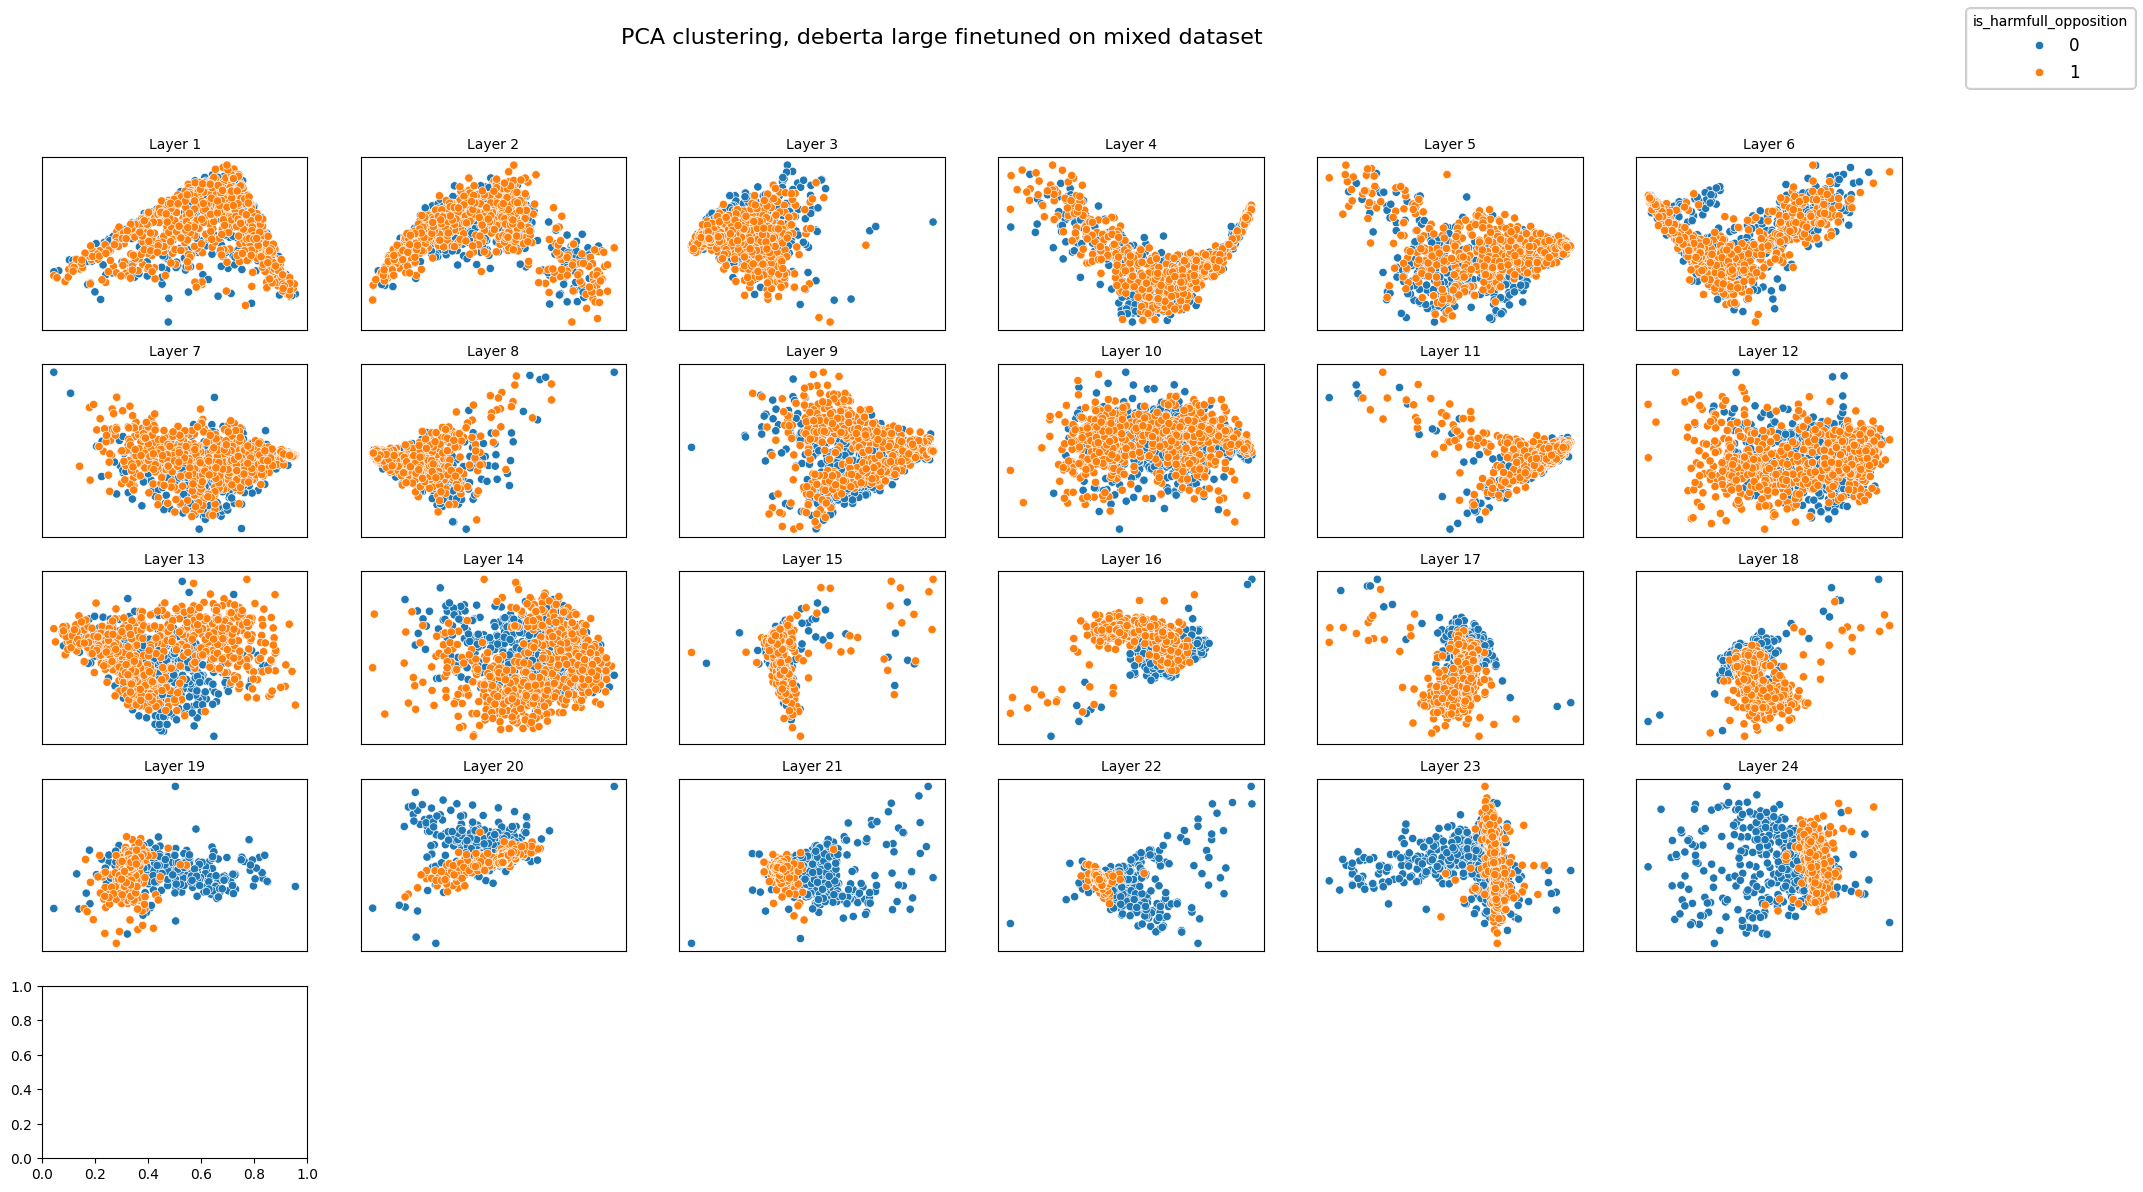

In [ ]:
X_pos_normalized_not = X_pos_not.reshape(-1, X_pos_not.shape[-1])         # (512*25, 768)
X_pos_normalized_not = normalize(X_pos_normalized_not, norm='l2', axis=1).reshape(X_pos_not.shape)

X_neg_normalized_not = X_neg_not.reshape(-1, X_neg_not.shape[-1])         # (512*25, 768)
X_neg_normalized_not = normalize(X_neg_normalized_not, norm='l2', axis=1).reshape(X_neg_not.shape)


plot_pca_or_tsne_layerwise(X_pos_normalized_not,
                           X_neg_normalized_not,
                           hate_total_not_yes_data['is_harmfull_opposition'],
                           standardize=False, n_components=5,
                           components=[0, 1], mode='pca',
                           plot_title='PCA clustering, deberta large finetuned on not dataset') 

#### **4.1. TTT dataset.**

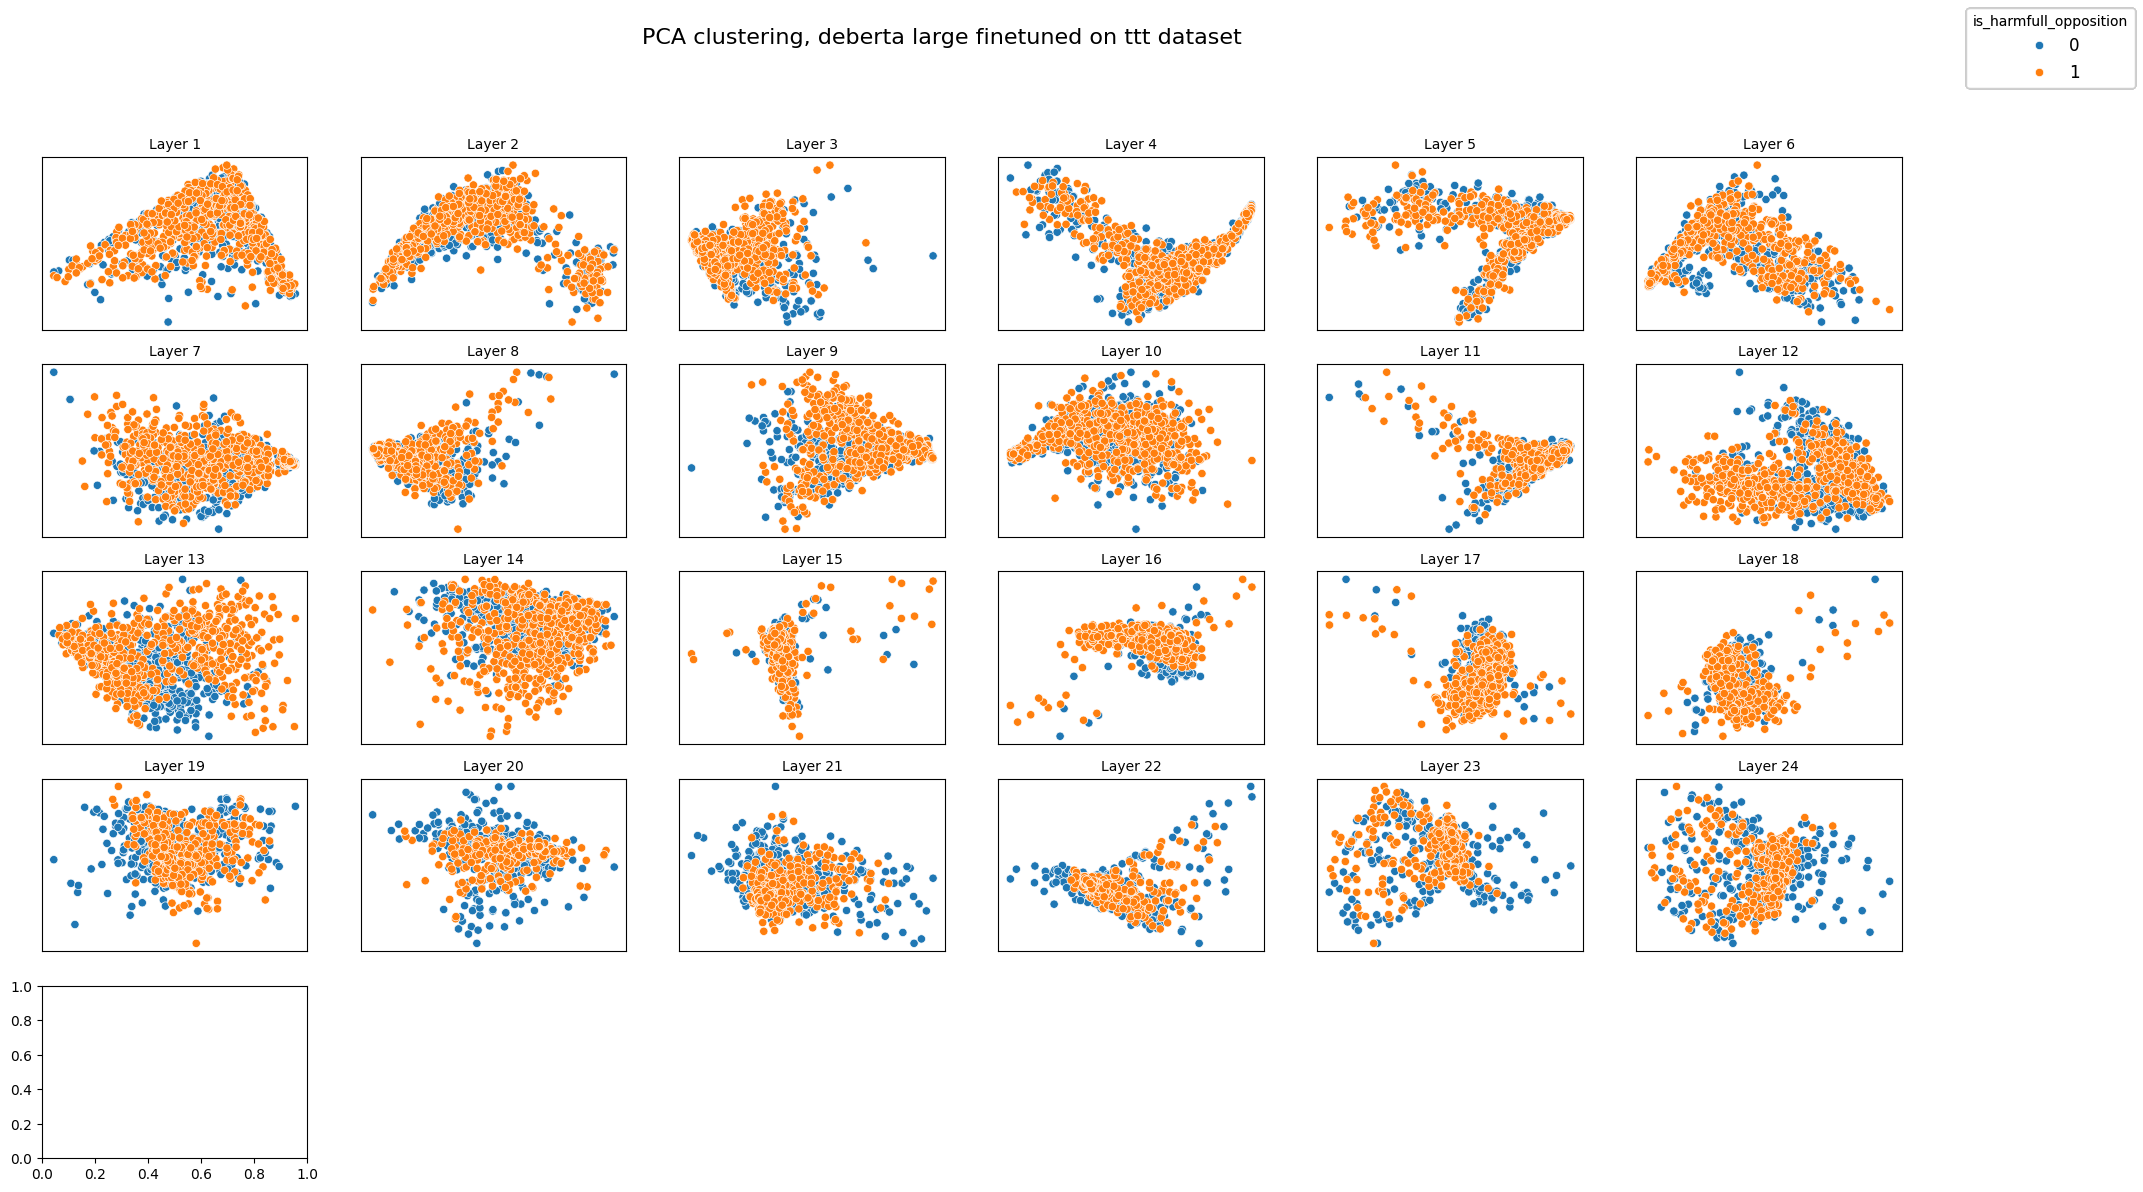

In [81]:
X_pos_normalized_ttt = X_pos_ttt.reshape(-1, X_pos_ttt.shape[-1])         # (512*25, 768)
X_pos_normalized_ttt = normalize(X_pos_normalized_ttt, norm='l2', axis=1).reshape(X_pos_ttt.shape)

X_neg_normalized_ttt = X_neg_ttt.reshape(-1, X_neg_mixed.shape[-1])         # (512*25, 768)
X_neg_normalized_ttt = normalize(X_neg_normalized_ttt, norm='l2', axis=1).reshape(X_neg_ttt.shape)


plot_pca_or_tsne_layerwise(X_pos_normalized_ttt,
                           X_neg_normalized_ttt,
                           hate_total_not_no_rnd_check['is_harmfull_opposition'],
                           standardize=False, n_components=5,
                           components=[0, 1], mode='pca',
                           plot_title='PCA clustering, deberta large finetuned on ttt dataset')

## **5. Find best CCS**


To find the best layers, train CCS on all hidden states. You can use different normalization strategies, the best in experiments was l2 + median.

In [ ]:
from ccs import CCS, train_ccs_on_hidden_states
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


# Train-test indexes (for all mixed experiments)
#idx = np.arange(len(hate_total_yes_data))
idx = np.arange(len(X_pos_normalized_mixed))
train_idx, test_idx = train_test_split(idx, test_size=0.20, random_state=71, shuffle=True)


# train CCS on normalized states
ccs_mixed_data = train_ccs_on_hidden_states(X_pos_normalized_mixed,
                                        X_neg_normalized_mixed,
                                        hate_total_yes_data['is_harmfull_opposition'], # y vector
                                         train_idx,
                                         test_idx,
                                        normalizing='median')

Training CCS on hidden states: 100%|██████████| 25/25 [05:01<00:00, 12.06s/it]


In [ ]:
# Train-test indexes (for not and ttt  experiments)
#idx = np.arange(len(hate_total_yes_data))
idx = np.arange(len(X_pos_normalized_not))
train_idx, test_idx = train_test_split(idx, test_size=0.20, random_state=71, shuffle=True)

In [89]:
# train CCS on normalized states
not_ccs = train_ccs_on_hidden_states(X_pos_normalized_not,
                                        X_neg_normalized_not,
                                        hate_total_not_yes_data['is_harmfull_opposition'],
                                         train_idx,
                                         test_idx,
                                        normalizing='median')

Training CCS on hidden states: 100%|██████████| 25/25 [04:43<00:00, 11.35s/it]


In [90]:
# train CCS on normalized states
ttt_ccs = train_ccs_on_hidden_states(X_pos_normalized_ttt,
                                        X_neg_normalized_ttt,
                                        hate_total_not_yes_rnd_check['is_harmfull_opposition'],
                                        train_idx,
                                        test_idx,
                                        normalizing='median')

Training CCS on hidden states: 100%|██████████| 25/25 [04:38<00:00, 11.13s/it]


After that, we train the CCS on the selected layer to obtain the probe and its weights.

I DON'T UNDERSTAND WHY THE ACCURACY IS DIFFERENT AND I DON'T SEE THE BUG AT ALL

## **7. Plot results tables.**

In [94]:
from format_results import get_results_table


deberta_pretr_mixed_ccs_table = get_results_table(ccs_mixed_data)
deberta_pretr_not_ccs_table = get_results_table(not_ccs)
deberta_pretr_ttt_ccs_table = get_results_table(ttt_ccs)

In [95]:
metrics = ['accuracy', 'polar_consistency_↓', 
       'contradiction_idx_↓']

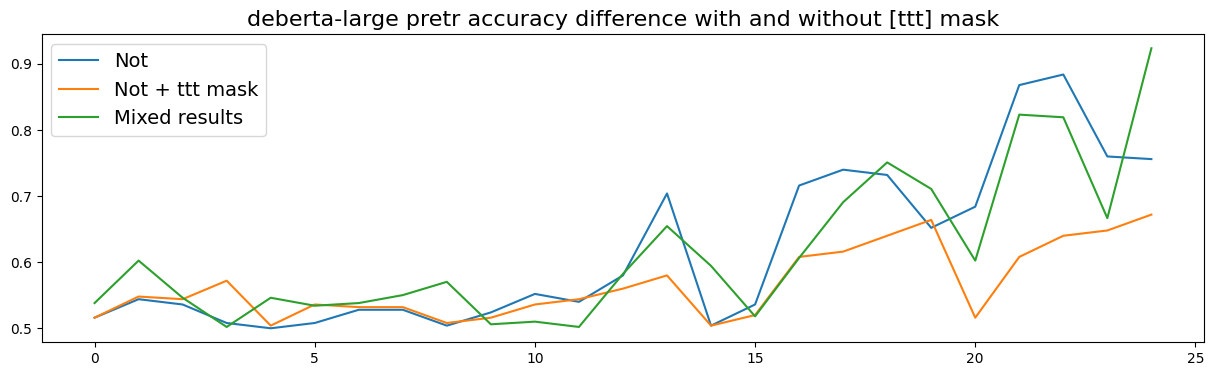

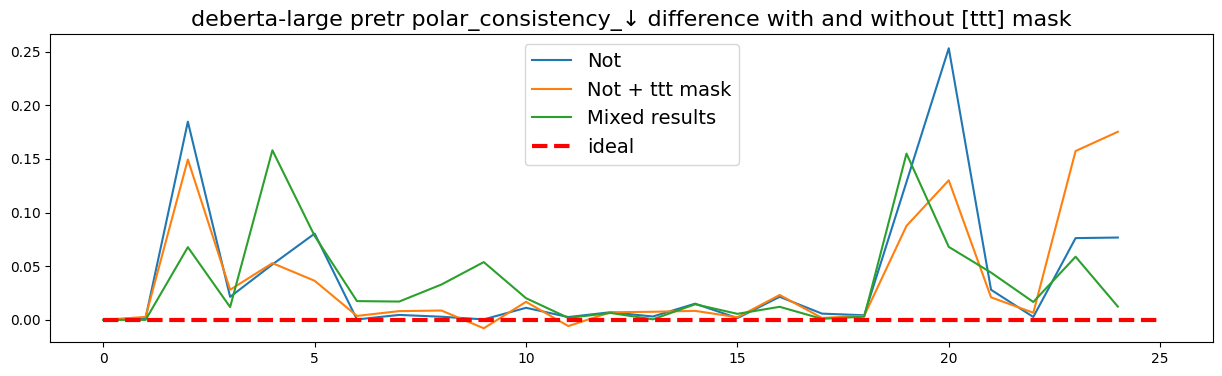

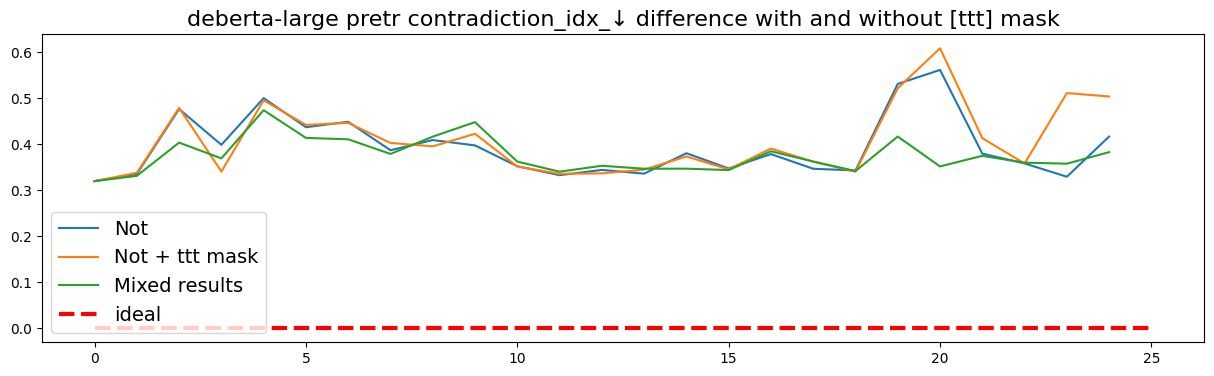

In [102]:
for idx, metric in enumerate(metrics):
    fig = plt.figure(figsize=(15, 4))
    plt.plot(deberta_pretr_not_ccs_table[metric], label='Not')
    plt.plot(deberta_pretr_ttt_ccs_table[metric], label='Not + ttt mask')
    plt.plot(deberta_pretr_mixed_ccs_table[metric], label='Mixed results')
    
    if idx != 0:
        plt.hlines(0, 0, 25, label='ideal', colors='red', linewidth=3, linestyles='--')
    plt.legend(fontsize=14)
    plt.title('deberta-large pretr '+metric+' difference with and without [ttt] mask', fontsize=16)
    plt.show()